In [1]:
# Au début du notebook
import time
start_time = time.time()

<h1 style="text-align:center;color:#06344ef6;font-size:50px;font-family:Bell MT ;border:solid"> Initiation au machine learning : Projet final 2024 - 2025</h1>

## Sommaire

Nous utiliserons l'ensemble de données [Ames Housing](http://jse.amstat.org/v19n3/decock.pdf) qui a été compilé pour la première fois par Dean De Cock. Il s'agit d'un ensemble de 1 460 maisons résidentielles à Ames, dans l'Iowa, chacune décrite par 80 caractéristiques. Nous l'utiliserons pour prédire le prix final des maisons. Dans cet exemple, nous n'utiliserons que les **n** caractéristiques les plus intéressantes.



**<h1 style="color:#06344ef6;text-align:center;font-size:35px;font-family:Bodoni MT"> MODELISATION </h1>**


## importation des modules

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as LGBMRegressor
from yellowbrick.regressor import ResidualsPlot
import missingno as msno
import pickle
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
data= pd.read_csv("../data/data_apuree.csv")
data.head(3)


Prix de vente                           Type de logement  \
0      12.247699               2 ÉTAGES 1946 ET PLUS RÉCENT   
1      12.109016  1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES   
2      12.317171               2 ÉTAGES 1946 ET PLUS RÉCENT   

     Zonage (Classification)  Façade (en pieds)  Superficie du lot (pieds²)  \
0  Résidentiel basse densité               65.0                      8450.0   
1  Résidentiel basse densité               80.0                      9600.0   
2  Résidentiel basse densité               68.0                     11250.0   

  Type de route           Forme du lot Topographie du terrain  \
0          Pavé               Régulier            Plat/Niveau   
1          Pavé               Régulier            Plat/Niveau   
2          Pavé  Légèrement irrégulier            Plat/Niveau   

                        Services publics disponibles Configuration du lot  \
0  Tous les services publics (Électricité, Gaz, E...        Lot intérieur   
1  Tous les services publics (Électricité, Gaz, E...        Double façade   
2  Tous les services publics (Électricité, Gaz, E...        Lot intérieur   

   ... Climatisation centrale Système électrique Surface du premier étage  \
0  ...                    Oui       Disjoncteurs                    856.0   
1  ...                    Oui       Disjoncteurs                   1262.0   
2  ...                    Oui       Disjoncteurs                    920.0   

  Surface du deuxième étage Surface finie basse qualité (pieds²)  \
0                     854.0                                  0.0   
1                       0.0                                  0.0   
2                     866.0                                  0.0   

  Surface habitable totale Salles de bain complètes sous-sol  \
0                   1710.0                               1.0   
1                   1262.0                               0.0   
2                   1786.0                               1.0   

  Demi-salles de bain sous-sol  Salles de bain complètes  Demi-salles de bain  
0                          0.0                       2.0                  1.0  
1                          1.0                       2.0                  0.0  
2                          0.0                       2.0                  1.0  

[3 rows x 49 columns]

### FONCTIONS POUR PERFORMANCES DES MODELES

In [4]:
def get_all_performances(value_train: tuple,
                         values_test: tuple,
                         metrics: list,
                        ) -> pd.DataFrame:
    """ Get all performance metrics listed in `metrics`

    Args:
        value_train (tuple): (y_train, y_train_pred)
        values_test (tuple): (y_test, y_test_pred)
        metrics (list): list of metrics to compute


    Returns:
        pd.DataFrame: column names are: ["metric", "train", "test"]

    """
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [5]:
METRICS = [metrics.r2_score,
           metrics.root_mean_squared_error,
           metrics.mean_absolute_percentage_error,
           metrics.max_error,
          ]

In [6]:
def get_input_features(model_pipeline, cat_step_name=None, ode_step_name=None):
    """
    Récupérer les noms des caractéristiques après transformation dans un pipeline.

    Parameters:
    - model_pipeline : pipeline complet du modèle avec un ColumnTransformer.
    - cat_step_name : nom de l'étape de prétraitement pour les variables catégorielles (optionnel).
    - ode_step_name : nom de l'étape de prétraitement pour les variables ordinales (optionnel).

    Returns:
    - Liste des noms de toutes les caractéristiques après transformation.
    """
    # Accéder au préprocesseur (ColumnTransformer) dans le pipeline
    col_trans = model_pipeline.named_steps['preprocessing']

    all_feature_names = []

    # Boucle sur chaque transformer dans le ColumnTransformer
    for step_name, pipe_trans, feat_names in col_trans.transformers_:
        if step_name == cat_step_name:
            # Récupérer les noms des caractéristiques après l'encodage OneHotEncoder
            if 'ohe' in pipe_trans.named_steps:  # Vérifie si le pipeline a un OneHotEncoder
                cat_feature_names = pipe_trans.named_steps['ohe'].get_feature_names_out(input_features=feat_names)
                all_feature_names.extend(cat_feature_names)
        elif step_name == ode_step_name:
            # Récupérer les noms des caractéristiques après l'encodage OrdinalEncoder
            if 'ode' in pipe_trans.named_steps:  # Vérifie si le pipeline a un OrdinalEncoder
                ode_feature_names = pipe_trans.named_steps['ode'].categories_[0]  # Cela renvoie les catégories de l'OrdinalEncoder
                all_feature_names.extend(ode_feature_names)
        else:
            # Ajouter les noms des caractéristiques pour les autres étapes (numériques)
            all_feature_names.extend(feat_names)

    # Retourner tous les noms des caractéristiques
    return all_feature_names

### Importation

In [7]:
# Importation
data = pd.read_csv('../data/data_apuree.csv')

In [8]:
data.shape
data

Prix de vente                           Type de logement  \
0         12.247699               2 ÉTAGES 1946 ET PLUS RÉCENT   
1         12.109016  1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES   
2         12.317171               2 ÉTAGES 1946 ET PLUS RÉCENT   
3         11.849405               2 ÉTAGES 1945 ET PLUS ANCIEN   
4         12.429220               2 ÉTAGES 1946 ET PLUS RÉCENT   
...             ...                                        ...   
1455      12.072547               2 ÉTAGES 1946 ET PLUS RÉCENT   
1456      12.254868  1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES   
1457      12.493133               2 ÉTAGES 1945 ET PLUS ANCIEN   
1458      11.864469  1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES   
1459      11.901590  1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES   

        Zonage (Classification)  Façade (en pieds)  \
0     Résidentiel basse densité               65.0   
1     Résidentiel basse densité               80.0   
2     Résidentiel basse densité               68.0   
3     Résidentiel basse densité               60.0   
4     Résidentiel basse densité               84.0   
...                         ...                ...   
1455  Résidentiel basse densité               62.0   
1456  Résidentiel basse densité               85.0   
1457  Résidentiel basse densité               66.0   
1458  Résidentiel basse densité               68.0   
1459  Résidentiel basse densité               75.0   

      Superficie du lot (pieds²) Type de route           Forme du lot  \
0                         8450.0          Pavé               Régulier   
1                         9600.0          Pavé               Régulier   
2                        11250.0          Pavé  Légèrement irrégulier   
3                         9550.0          Pavé  Légèrement irrégulier   
4                        14260.0          Pavé  Légèrement irrégulier   
...                          ...           ...                    ...   
1455                      7917.0          Pavé               Régulier   
1456                     13175.0          Pavé               Régulier   
1457                      9042.0          Pavé               Régulier   
1458                      9717.0          Pavé               Régulier   
1459                      9937.0          Pavé               Régulier   

     Topographie du terrain  \
0               Plat/Niveau   
1               Plat/Niveau   
2               Plat/Niveau   
3               Plat/Niveau   
4               Plat/Niveau   
...                     ...   
1455            Plat/Niveau   
1456            Plat/Niveau   
1457            Plat/Niveau   
1458            Plat/Niveau   
1459            Plat/Niveau   

                           Services publics disponibles Configuration du lot  \
0     Tous les services publics (Électricité, Gaz, E...        Lot intérieur   
1     Tous les services publics (Électricité, Gaz, E...        Double façade   
2     Tous les services publics (Électricité, Gaz, E...        Lot intérieur   
3     Tous les services publics (Électricité, Gaz, E...          Lot d'angle   
4     Tous les services publics (Électricité, Gaz, E...        Double façade   
...                                                 ...                  ...   
1455  Tous les services publics (Électricité, Gaz, E...        Lot intérieur   
1456  Tous les services publics (Électricité, Gaz, E...        Lot intérieur   
1457  Tous les services publics (Électricité, Gaz, E...        Lot intérieur   
1458  Tous les services publics (Électricité, Gaz, E...        Lot intérieur   
1459  Tous les services publics (Électricité, Gaz, E...        Lot intérieur   

      ... Climatisation centrale Système électrique Surface du premier étage  \
0     ...                    Oui       Disjoncteurs                    856.0   
1     ...                    Oui       Disjoncteurs                   1262.0   
2     ...                    Oui       Disjoncteurs                    920.0   
3     ...                    Oui 

In [9]:
data.describe()

Prix de vente  Façade (en pieds)  Superficie du lot (pieds²)  \
count    1460.000000        1460.000000                 1460.000000   
mean       12.023088          69.115068                 9682.476712   
std         0.352713          16.503986                 3469.444734   
min        11.385103          36.000000                 3316.000000   
25%        11.775105          60.000000                 7553.500000   
50%        12.001512          69.000000                 9478.500000   
75%        12.273736          79.000000                11601.500000   
max        12.694656         104.000000                17400.000000   

       Année de construction  Année de rénovation  \
count            1460.000000          1460.000000   
mean             1971.787671          1984.865753   
std                28.872129            20.645407   
min              1916.000000          1950.000000   
25%              1954.000000          1967.000000   
50%              1973.000000          1994.000000   
75%              2000.000000          2004.000000   
max              2007.000000          2010.000000   

       Surface de parement (pieds²)  Surface finie sous-sol  \
count                   1460.000000             1460.000000   
mean                      92.047945              431.089041   
std                      140.590668              412.214952   
min                        0.000000                0.000000   
25%                        0.000000                0.000000   
50%                        0.000000              383.500000   
75%                      164.250000              712.250000   
max                      456.000000             1274.000000   

       Surface finie sous-sol 2  Surface non finie sous-sol  \
count               1460.000000                 1460.000000   
mean                  32.921233                  556.537671   
std                  100.533075                  414.582219   
min                    0.000000                    0.000000   
25%                    0.000000                  223.000000   
50%                    0.000000                  477.500000   
75%                    0.000000                  808.000000   
max                  396.000000                 1468.000000   

       Total surface sous-sol  Surface du premier étage  \
count             1460.000000               1460.000000   
mean              1055.985616               1151.851370   
std                346.847701                333.655006   
min                520.000000                673.000000   
25%                795.750000                882.000000   
50%                991.500000               1087.000000   
75%               1298.250000               1391.250000   
max               1753.000000               1831.000000   

       Surface du deuxième étage  Surface finie basse qualité (pieds²)  \
count                1460.000000                                1460.0   
mean                  337.728767                                   0.0   
std                   415.251008                                   0.0   
min                     0.000000                                   0.0   
25%                     0.000000                                   0.0   
50%                     0.000000                                   0.0   
75%                   728.000000                                   0.0   
max                  1141.000000                                   0.0   

       Surface habitable totale  Salles de bain complètes sous-sol  \
count               1460.000000                        1460.000000   
mean                1498.917123                           0.413699   
std                  450.721489                           0.492665   
min                  848.000000                           0.000000   
25%                 1129.500000                           0.000000   
50%                 1464.000000                           0.000000   
75%                 1776.750000                           1.0000

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Prix de vente                         1460 non-null   float64
 1   Type de logement                      1460 non-null   object 
 2   Zonage (Classification)               1460 non-null   object 
 3   Façade (en pieds)                     1460 non-null   float64
 4   Superficie du lot (pieds²)            1460 non-null   float64
 5   Type de route                         1460 non-null   object 
 6   Forme du lot                          1460 non-null   object 
 7   Topographie du terrain                1460 non-null   object 
 8   Services publics disponibles          1460 non-null   object 
 9   Configuration du lot                  1460 non-null   object 
 10  Inclinaison du terrain                1460 non-null   object 
 11  Quartier         

In [11]:
variables_qualitatives = data.select_dtypes(include=['object', 'category']).columns
variables_qualitatives
# Identification des colonnes numériques
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('Prix de vente')
print(numeric_cols, variables_qualitatives)

['Façade (en pieds)', 'Superficie du lot (pieds²)', 'Année de construction', 'Année de rénovation', 'Surface de parement (pieds²)', 'Surface finie sous-sol', 'Surface finie sous-sol 2', 'Surface non finie sous-sol', 'Total surface sous-sol', 'Surface du premier étage', 'Surface du deuxième étage', 'Surface finie basse qualité (pieds²)', 'Surface habitable totale', 'Salles de bain complètes sous-sol', 'Demi-salles de bain sous-sol', 'Salles de bain complètes', 'Demi-salles de bain'] Index(['Type de logement', 'Zonage (Classification)', 'Type de route',
       'Forme du lot', 'Topographie du terrain',
       'Services publics disponibles', 'Configuration du lot',
       'Inclinaison du terrain', 'Quartier', 'Proximité (1ère condition)',
       'Proximité (2e condition)', 'Type de bâtiment', 'Style de maison',
       'Qualité globale', 'État général', 'Style de toit', 'Matériau du toit',
       'Revêtement extérieur (1)', 'Revêtement extérieur (2)',
       'Qualité extérieure', 'État exté

## Sélection des variables explicatives

In [12]:
#  soit votre DataFrame et 'SalePrice' la variable cible
X = data.drop(columns=['Prix de vente'])

y = data['Prix de vente']


In [13]:
X_encode = pd.get_dummies(data=X,
                          columns=variables_qualitatives,
                          drop_first=True,
                         )
X_encode.shape

(1460, 190)

Création des variables Dummy pour les index des feature importances

In [14]:
# Colonnes à encoder ordinalement
ode_cols =['LotShape','LandSlope',
    'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC'

]
ode_cols=[
    'Façade (en pieds)', 'Superficie du lot (pieds²)', 'Année de construction',
    'Année de rénovation', 'Surface de parement (pieds²)', 'Surface finie sous-sol',
    'Surface finie sous-sol 2', 'Surface non finie sous-sol', 'Total surface sous-sol',
    'Surface du premier étage', 'Surface du deuxième étage',
    'Surface finie basse qualité (pieds²)', 'Surface habitable totale',
    'Salles de bain complètes sous-sol', 'Demi-salles de bain sous-sol',
    'Salles de bain complètes', 'Demi-salles de bain'
]

# Colonnes à encoder en one-hot
ohe_cols =[
    'MSSubClass', 'MSZoning', 'Street',  'LandContour', 'Utilities',
    'LotConfig',  'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'Foundation', 'Heating', 'CentralAir','Electrical'
]

ohe_cols=[
    'Type de logement', 'Zonage (Classification)', 'Type de route', 'Forme du lot',
    'Topographie du terrain', 'Services publics disponibles', 'Configuration du lot',
    'Inclinaison du terrain', 'Quartier', 'Proximité (1ère condition)',
    'Proximité (2e condition)', 'Type de bâtiment', 'Style de maison',
    'Qualité globale', 'État général', 'Style de toit', 'Matériau du toit',
    'Revêtement extérieur (1)', 'Revêtement extérieur (2)', 'Qualité extérieure',
    'État extérieur', 'Type de fondation', 'Qualité du sous-sol',
    'État général du sous-sol', 'Exposition du sous-sol',
    'Type de finition sous-sol (1)', 'Type de finition sous-sol (2)',
    'Type de chauffage', 'Qualité du chauffage', 'Climatisation centrale',
    'Système électrique'
]

### Pipelines

Dans le cadre de notre pipeline, nous appliquerons les étapes suivantes:

- **Standardisation des variables quantitatives**: Nous centrerons et réduirons ces variables afin de les ramener à une échelle commune, avec une moyenne nulle et un écart-type égal à un.

- **Encodage des variables catégorielles**: Nous transformerons ces variables en variables indicatrices (dummy variables) pour les rendre exploitables par les algorithmes d'apprentissage automatique.

Ces transformations permettront d'optimiser les performances de notre modèle en assurant une meilleure comparabilité des variables et en facilitant leur interprétation.

In [15]:
# Pipeline pour les variables numériques
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler())  # Normalisation
])
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encodage ordinal, handle unknown categories
])


# Pipeline pour les variables avec encodage one-hot
onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))  # Encodage one-hot
])


In [16]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('ord', ordinal_pipeline, ode_cols),
    ('ohe', onehot_pipeline, ohe_cols)
])


In [17]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie...
                                                   'Qualité globale',
                                                   'État général',
                                                   'Style de toit',
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])]))])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1095 lignes,
Test: 365 lignes.



## REGRESSION LINEAIRE

In [19]:
lr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("regressor", LinearRegression())
    ]
)

In [20]:
# definir les hyperparametres
param_grid_lr = {
    "regressor__fit_intercept": [True, False],
}

GS_lr = GridSearchCV(lr_pipe, param_grid_lr, cv=10, scoring="r2", return_train_score=True)
GS_lr

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fin...
                                                                          'Exposition '
                                                                          'du '
                                                                          'sous-sol',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(1)',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                    

In [21]:
# Exécuter la recherche sur la grille
GS_lr.fit(X_train, y_train)
# meilleur combinaison
best_params = GS_lr.best_params_
print(f"Best params: {best_params}")


Best params: {'regressor__fit_intercept': True}


In [22]:
grid_cv_results = GS_lr.cv_results_
pd.DataFrame(grid_cv_results)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.568577      0.146535         0.026826        0.009584   
1       0.680540      0.141512         0.031015        0.012334   

  param_regressor__fit_intercept                               params  \
0                           True   {'regressor__fit_intercept': True}   
1                          False  {'regressor__fit_intercept': False}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.827031           0.652703           0.769681           0.862479   
1           0.822881           0.456663           0.756026           0.848158   

   ...  split2_train_score  split3_train_score  split4_train_score  \
0  ...            0.934755            0.936311            0.935966   
1  ...            0.933996            0.935738            0.935665   

   split5_train_score  split6_train_score  split7_train_score  \
0            0.934379            0.934716            0.940731   
1            0.933565            0.934384            0.939985   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0            0.936183            0.937328          0.936279         0.001715  
1            0.935690            0.936949          0.935742         0.001706  

[2 rows x 31 columns]

In [23]:
# predictions
y_test_pred_lr = GS_lr.predict(X_test)
y_train_pred_lr = GS_lr.predict(X_train)

In [24]:
## Comparaison réelle et prédiction (train et test)
fig = make_subplots(rows=1, cols=2, shared_yaxes=False)

datasets = [("Train", y_train, y_train_pred_lr), ("Test", y_test, y_test_pred_lr)]

for idx, (name, y_true, y_pred) in enumerate(datasets):
    col = idx + 1
    fig.add_trace(go.Scatter(x=y_true, y=y_pred, mode="markers", name=name), row=1, col=col)

    fig.add_trace(go.Scatter(x=[y_true.min(), y_true.max()],
                             y=[y_true.min(), y_true.max()],
                             mode="lines", name="Diagonal", line=dict(color="black", dash="dash")),
                  row=1, col=col)

fig.update_layout(title_text="Comparaison réelle et prédiction (train et test)", showlegend=True)
fig.show()


## RESIDUS

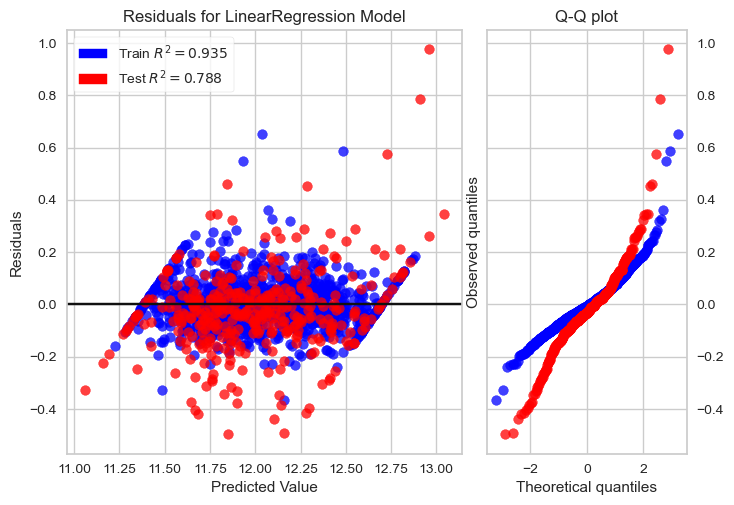

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

<Figure size 800x550 with 0 Axes>

In [25]:
# Visualisation des résidus
from yellowbrick.regressor import ResidualsPlot

res_viz = ResidualsPlot(lr_pipe,
                        is_fitted="auto",
                        qqplot=True,
                        hist=False,
                        train_color="blue",
                        test_color="red"
                       )
res_viz.fit(X_train, y_train)
res_viz.score(X_test, y_test)
res_viz.show(clear_figure=True)


In [26]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, GS_lr.predict(X_train)),
                     values_test=(y_test, GS_lr.predict(X_test)),
                     metrics=METRICS
                    )
perform
joblib.dump(perform, '../ressource/performance/GS_lr_perform.pkl')
joblib.dump(GS_lr, '../ressource/modele/GS_lr_model.pkl')

['../ressource/modele/GS_lr_model.pkl']

# ELASTIC NET

In [27]:
EN_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", ElasticNet())]
)
EN_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Style de toit',
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', ElasticNet())])

In [28]:
EN_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Style de toit',
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', ElasticNet())])

In [29]:
# predictions
y_test_pred_EN = EN_pipe.predict(X_test)
y_train_pred_EN = EN_pipe.predict(X_train)

In [30]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, y_train_pred_EN),
                     values_test=(y_test, y_test_pred_EN),
                     metrics=METRICS)
perform

metric     train      test
0                        r2_score  0.818061  0.127311
1         root_mean_squared_error  0.149984  0.332076
2  mean_absolute_percentage_error  0.009171  0.020386
3                       max_error  0.762891  1.034465

### Optimisation des hyperparametres

In [31]:
# optimisation des hyperparamètres
param_grid_EN = {
    "regressor__alpha": [0.005, 0.01, 0.2, 0.3, 0.5, 0.7],
    "regressor__l1_ratio" : [0.001, 0.01, 0.5, 0.3, 0.7, 0.8],
    "regressor__fit_intercept" : [True, False]
}

GS_EN = GridSearchCV(EN_pipe, param_grid_EN, cv=5, scoring="r2", return_train_score=True)

In [32]:
# les meilleurs paramètres
GS_EN.fit(X_train, y_train)

best_params = GS_EN.best_params_
print(f"Best params: {best_params}")

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.076649040847948, tolerance: 0.011140301377969487

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.030050121920033, tolerance: 0.01074974732432053

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.021304957574464, tolerance: 0.010597465337453253

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7970322598729784, tolerance

Best params: {'regressor__alpha': 0.005, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.001}


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.146531662121204, tolerance: 0.013538631495021224



In [33]:
# entrainement du meilleur modele
best_elasticnet_model = GS_EN.best_estimator_
best_elasticnet_model.fit(X_train,y_train)

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.146531662121204, tolerance: 0.013538631495021224



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', ElasticNet(alpha=0.005, l1_ratio=0.001))])

In [34]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, best_elasticnet_model.predict(X_train)),
                     values_test=(y_test, best_elasticnet_model.predict(X_test)),
                     metrics=METRICS
                    )
perform

metric     train      test
0                        r2_score  0.930233  0.826963
1         root_mean_squared_error  0.092877  0.147869
2  mean_absolute_percentage_error  0.005699  0.008929
3                       max_error  0.667763  0.904705

In [35]:
joblib.dump(perform, '../ressource/performance/ElasticNet_perform.pkl')
joblib.dump(best_elasticnet_model, '../ressource/modele/ElasticNet_model.pkl')

['../ressource/modele/ElasticNet_model.pkl']

# Random Forest

In [36]:
randf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor())]
)
randf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', RandomForestRegressor())])

In [37]:
# Premier entrainement
randf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', RandomForestRegressor())])

In [38]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, randf_pipe.predict(X_train)),
                     values_test=(y_test, randf_pipe.predict(X_test)),
                     metrics=METRICS)
perform

metric     train      test
0                        r2_score  0.983765  0.742927
1         root_mean_squared_error  0.044803  0.180234
2  mean_absolute_percentage_error  0.002704  0.011284
3                       max_error  0.290586  0.706702

Optimisation des Hyperparametres

In [39]:
# optimisation des hyperparamètres
param_grid_rf = {
    'regressor__n_estimators': [700, 600],
     'regressor__min_samples_split': [5],
    'regressor__max_depth': [None],
    'regressor__min_samples_leaf': [2],
    #'regressor__max_features': ['auto'],#'sqrt'
    'regressor__bootstrap': [True], # False
}

GS_rf = GridSearchCV(randf_pipe, param_grid_rf, cv=5, scoring="r2", return_train_score=True)
GS_rf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [None],
                         'regressor__min_samples_leaf': [2],
                         'regressor__min_samples_split': [5],
                         'regressor__n_estimators': [700, 600]},
             return_train_score=True, scoring='r2')

In [40]:
# les meilleurs paramètres
GS_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [None],
                         'regressor__min_samples_leaf': [2],
                         'regressor__min_samples_split': [5],
                         'regressor__n_estimators': [700, 600]},
             return_train_score=True, scoring='r2')

In [41]:
# les meilleurs paramètres
best_params = GS_rf.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__bootstrap': True, 'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 700}


In [42]:
# entrainement du meilleur modele
best_randf_model = GS_rf.best_estimator_
best_randf_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor',
                 RandomForestRegressor(min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=700))])

## Evaluation des performances

In [43]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, best_randf_model.predict(X_train)),
                     values_test=(y_test, best_randf_model.predict(X_test)),
                     metrics=METRICS
                    )
perform
joblib.dump(perform, '../ressource/performance/rfr_perform.pkl')
joblib.dump(best_randf_model, '../ressource/modele/rfr_model.pkl')

['../ressource/modele/rfr_model.pkl']

Feature importance

In [44]:
# future importance
#df_feature_importance = pd.DataFrame(best_randf_model['regressor'].feature_importances_, columns=["coef"], index=X_encode.columns)
#print(f"Shape: {df_feature_importance.shape}")
#df_feature_importance.head()

In [45]:
#fig=plt.figure(figsize=[10,12])
#fig.patch.set_alpha(0.7)
#plt.title(" Répresentation des coefficients",size=18)
#plt.barh(X_encode.columns, best_randf_model['regressor'].feature_importances_,color="#0000FF",edgecolor='blue')


# XGBoost

In [46]:
xgb_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor())]
)
xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [47]:
# Premier entrainement
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [48]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, xgb_pipe.predict(X_train)),
                     values_test=(y_test, xgb_pipe.predict(X_test)),
                     metrics=METRICS)
perform

metric     train      test
0                        r2_score  0.999519  0.857058
1         root_mean_squared_error  0.007712  0.134396
2  mean_absolute_percentage_error  0.000433  0.008221
3                       max_error  0.042398  0.696676

### Optimisation des hyperparametres

In [49]:
# optimisation des hyperparamètres
param_grid_xgb = {
     "regressor__n_estimators" : [100, 200, 300],
    "regressor__max_depth" : [3, 6, 9],
    "regressor__gamma" : [0.01, 0.1],
    "regressor__learning_rate" : [0.001, 0.01, 0.1, 1]
}
GS_xgb = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5, scoring="r2", return_train_score=True)
GS_xgb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__gamma': [0.01, 0.1],
                         'regressor__learning_rate': [0.001, 0.01, 0.1, 1],
                         'regressor__max_depth': [3, 6, 9],
                         'regressor__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='r2')

In [50]:
# les meilleurs paramètres
GS_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__gamma': [0.01, 0.1],
                         'regressor__learning_rate': [0.001, 0.01, 0.1, 1],
                         'regressor__max_depth': [3, 6, 9],
                         'regressor__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='r2')

In [51]:
# les meilleurs paramètres
best_params = GS_xgb.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__gamma': 0.01, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


In [52]:
# entrainement du meilleur modele
best_xgb_model = GS_xgb.best_estimator_
best_xgb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                              feature_types=None, gamma=0.01, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Evaluation des performances

In [53]:
# predictions
y_train_predXGB = best_xgb_model.predict(X_train)
y_test_predXGB = best_xgb_model.predict(X_test)

# get performances in train & test
perform=get_all_performances(value_train=(y_train, y_train_predXGB),
                     values_test=(y_test, y_test_predXGB),
                     metrics=METRICS
                    )
perform
joblib.dump(perform, '../ressource/performance/xgb_perform.pkl')
joblib.dump(best_xgb_model, '../ressource/modele/xgb_model.pkl')

['../ressource/modele/xgb_model.pkl']

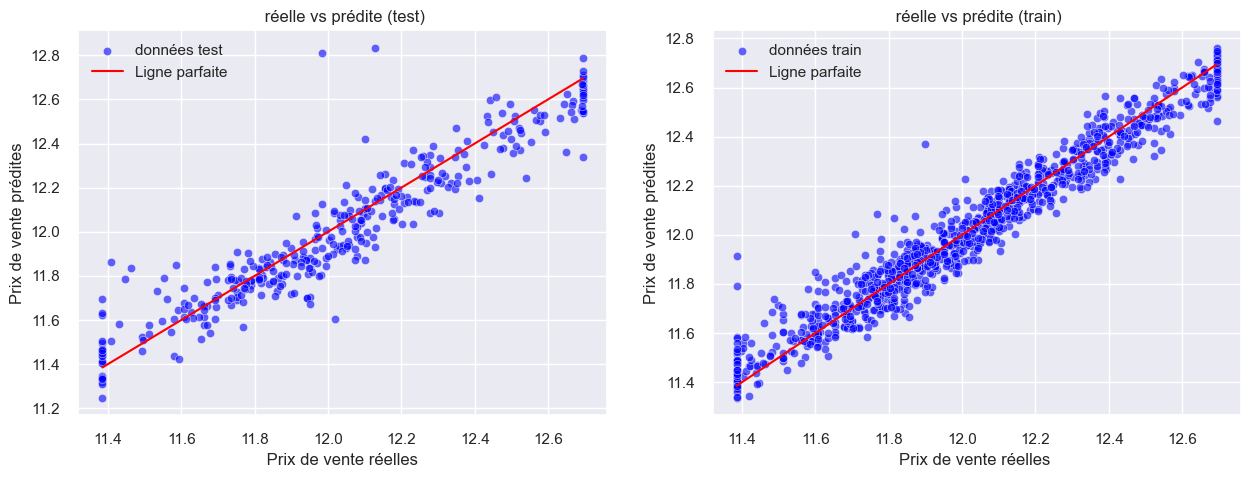

In [78]:
# graphique
sns.set()
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x = y_test, y = y_test_predXGB, alpha = 0.6, ax = axs[0], color='blue', label='données test')
sns.lineplot(x=y_test, y=y_test, ax = axs[0], color='red', label='Ligne parfaite')
axs[0].set_xlabel(" Prix de vente réelles ")
axs[0].set_ylabel("Prix de vente prédites")
axs[0].set_title(" réelle vs prédite (test)")
sns.scatterplot(x = y_train, y = y_train_predXGB, alpha = 0.6, ax = axs[1], color='blue', label='données train')
sns.lineplot(x=y_train, y=y_train, ax = axs[1], color='red', label='Ligne parfaite')
axs[1].set_xlabel("Prix de vente réelles ")
axs[1].set_ylabel("Prix de vente prédites")
axs[1].set_title(" réelle vs prédite (train)")
plt.show()

# Light GBM

In [55]:
from lightgbm import LGBMRegressor # import the LGBMRegressor class from the lightgbm module.

lgbm_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LGBMRegressor())]
)
lgbm_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', LGBMRegressor())])

In [56]:
# premier entrainement
lgbm_pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4293
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 152
[LightGBM] [Info] Start training from score 12.022632


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', LGBMRegressor())])

In [57]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, lgbm_pipe.predict(X_train)),
                     values_test=(y_test, lgbm_pipe.predict(X_test)),
                     metrics=METRICS
                    )
perform

metric     train      test
0                        r2_score  0.990086  0.873634
1         root_mean_squared_error  0.035011  0.126364
2  mean_absolute_percentage_error  0.002067  0.007705
3                       max_error  0.337777  0.724169

### Optimisation des hyperparametres

In [58]:
# optimisation des hyperparamètres
param_grid_lgb = {
    'regressor__num_leaves': [131, 255],
    'regressor__max_depth': [-1, 30],
    'regressor__learning_rate': [0.001, 0.2],
    'regressor__n_estimators': [10, 50],
   # 'regressor__min_split_gain': [0.0, 0.2],
    #'regressor__min_child_samples': [10, 30],
    #'regressor__subsample': [0.8, 0.9, 1.0],
    #'regressor__reg_alpha': [0.0, 0.1, 0.5],
    #'regressor__reg_lambda': [0.001, 0.1],
    #'regressor__objective': ['mse'],
    #'regressor__feature_fraction': 0.75,
    #'regressor__bagging_fraction': 0.75,
    #'regressor__bagging_freq': 5,
}

GS_lgb = GridSearchCV(lgbm_pipe, param_grid_lgb, cv=5, scoring="r2", return_train_score=True)
GS_lgb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(1)',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', LGBMRegressor())]),
             param_grid={'regressor__learning_rate': [0.001, 0.2],
                         'regressor__max_depth': [-1, 30],
                         'regressor__n_estimators': [10, 50],
                         'regressor__num_leaves': [131, 255]},
             return_train_score=True, scoring='r2')

In [59]:
# les meilleurs paramètres
GS_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 147
[LightGBM] [Info] Start training from score 12.014136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(1)',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', LGBMRegressor())]),
             param_grid={'regressor__learning_rate': [0.001, 0.2],
                         'regressor__max_depth': [-1, 30],
                         'regressor__n_estimators': [10, 50],
                         'regressor__num_leaves': [131, 255]},
             return_train_score=True, scoring='r2')

In [60]:
# les meilleurs paramètres
best_params = GS_lgb.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__learning_rate': 0.2, 'regressor__max_depth': -1, 'regressor__n_estimators': 50, 'regressor__num_leaves': 131}


In [61]:
# entrainement du meilleur modele
best_lgb_model = GS_lgb.best_estimator_
best_lgb_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4293
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 152
[LightGBM] [Info] Start training from score 12.022632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor',
                 LGBMRegressor(learning_rate=0.2, n_estimators=50,
                               num_leaves=131))])

In [62]:
# entrainement du meilleur modele
best_lgb_model = GS_lgb.best_estimator_
best_lgb_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4293
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 152
[LightGBM] [Info] Start training from score 12.022632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor',
                 LGBMRegressor(learning_rate=0.2, n_estimators=50,
                               num_leaves=131))])

In [63]:
perform=get_all_performances(value_train=(y_train, best_lgb_model.predict(X_train)),
                     values_test=(y_test, best_lgb_model.predict(X_test)),
                     metrics=METRICS
                    )
perform


metric     train      test
0                        r2_score  0.992667  0.855727
1         root_mean_squared_error  0.030112  0.135020
2  mean_absolute_percentage_error  0.001722  0.008239
3                       max_error  0.286900  0.710773

In [64]:
joblib.dump(perform, '../ressource/performance/lgb_perform.pkl')

['../ressource/performance/lgb_perform.pkl']

# CHOIX DU MODELE FINAL

In [65]:
# Regression lineaire
score_Lr_Train = GS_lr.score(X_train, y_train)
score_Lr_Test = GS_lr.score(X_test, y_test)

# ElasticNet
score_EN_Train = best_elasticnet_model.score(X_train, y_train)
score_EN_Test = best_elasticnet_model.score(X_test, y_test)

# Random Forest
score_RF_Train = best_randf_model.score(X_train, y_train)
score_RF_Test = best_randf_model.score(X_test, y_test)

# XGBoost
score_XGB_Train = best_xgb_model.score(X_train, y_train)
score_XGB_Test = best_xgb_model.score(X_test, y_test)

# Light GBM
score_LGB_Train = best_lgb_model.score(X_train, y_train)
score_LGB_Test = best_lgb_model.score(X_test, y_test)

C:\Users\pc\AppData\Local\Temp\ipykernel_6720\3152736353.py:12: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




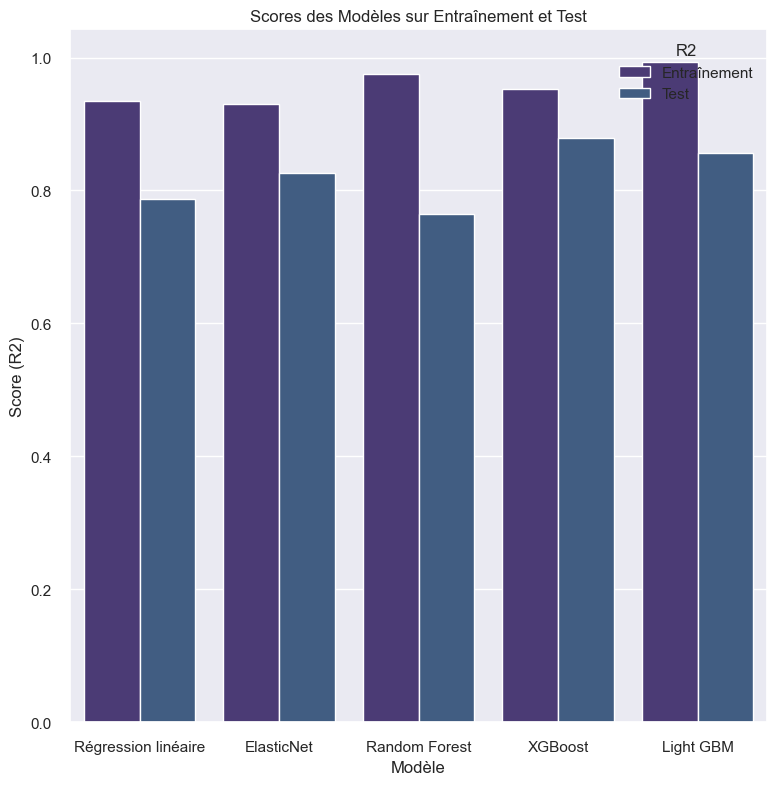

In [66]:
models = ['Régression linéaire', 'ElasticNet', 'Random Forest', 'XGBoost', 'Light GBM']
train_scores = [score_Lr_Train, score_EN_Train, score_RF_Train, score_XGB_Train, score_LGB_Train]
test_scores = [score_Lr_Test, score_EN_Test, score_RF_Test, score_XGB_Test, score_LGB_Test]

scores_df = pd.DataFrame({'Modèle': models * 2,
                          'Score': train_scores + test_scores,
                          'R2': ['Entraînement'] * len(models) + ['Test'] * len(models)})

sns.set_palette("viridis")

plt.figure(figsize=(9, 9))
sns.barplot(x='Modèle', y='Score', hue='R2', data=scores_df, ci=None)
plt.xlabel('Modèle')
plt.ylabel('Score (R2)')
plt.title('Scores des Modèles sur Entraînement et Test')
plt.legend(title='R2')

plt.show()

## Model final retenu : Light GBM

In [67]:
best_lgb_model.fit(X,y)
print (f'Score final - : {best_lgb_model.score(X,y):.7f}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4583
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 164
[LightGBM] [Info] Start training from score 12.023088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Prediction des prix des maisons

In [68]:
y_pred = best_lgb_model.predict(X_test)


## comparaisons des valeurs predites et des valeurs reelles

In [69]:
comparaison=pd.DataFrame(y_pred,columns=["Prédites"],index=y_test.index)
comparaison["Réelles"]=y
np.exp(comparaison.head())

Prédites   Réelles
400   244379.158821  245501.0
426   267185.412741  275001.0
310   171044.619671  165601.0
1176  120473.196344  119501.0
1170  168271.835010  171001.0

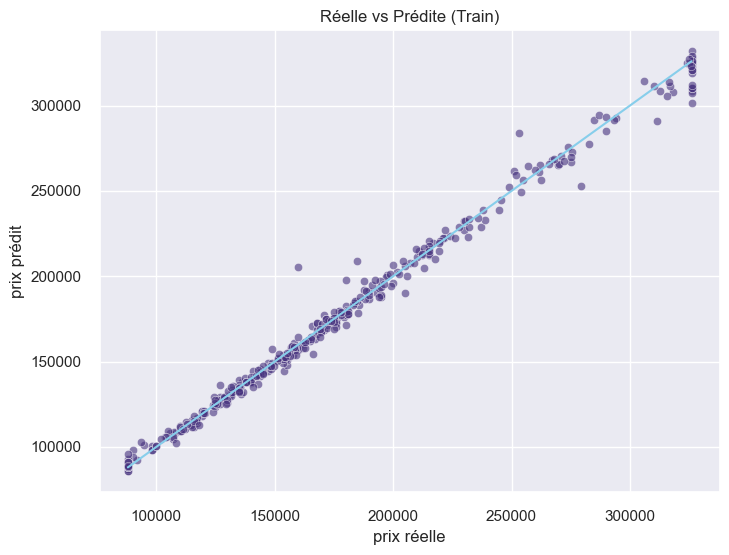

In [70]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred), alpha=0.6)
sns.lineplot(x=np.exp(y_test), y=np.exp(y_test), color='skyblue')  # Ligne de référence en rouge
plt.xlabel("prix réelle")
plt.ylabel("prix prédit")
plt.title("Réelle vs Prédite (Train)")

plt.show()

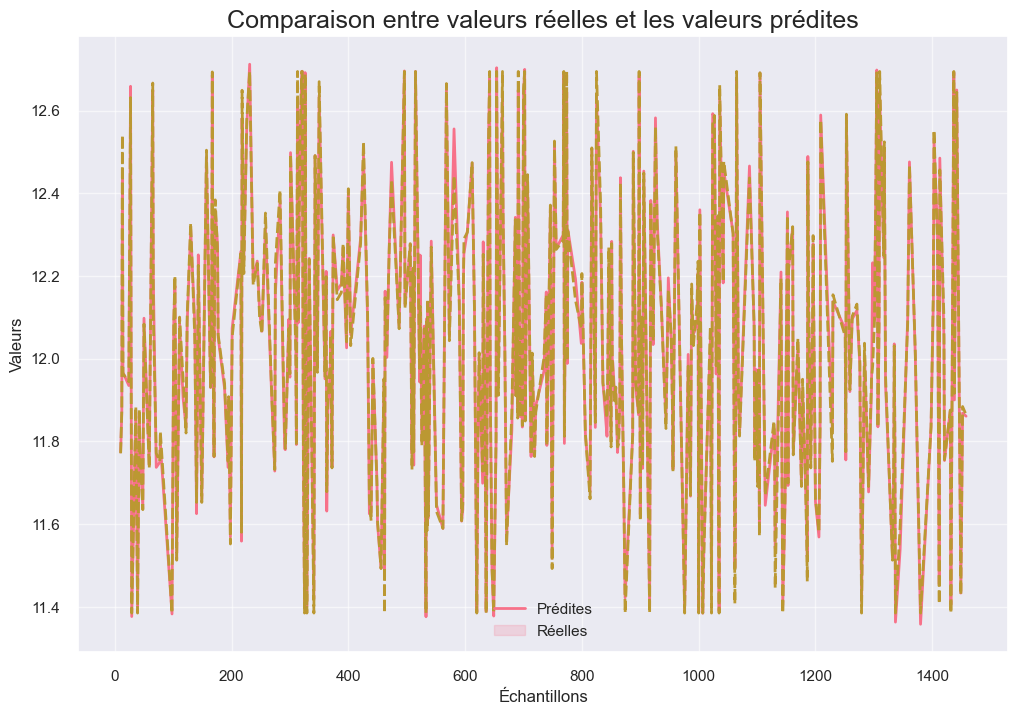

In [71]:
# graphique de comparaison
plt.figure(figsize=(12, 8))
sns.set_palette("husl")
sns.lineplot(data=comparaison[['Prédites', 'Réelles']], linewidth=2)
plt.title("Comparaison entre valeurs réelles et les valeurs prédites", size=18)
plt.xlabel("Échantillons")
plt.ylabel("Valeurs")
plt.legend(labels=['Prédites', 'Réelles'])
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

## Enrégistrement du modèle final

In [74]:
joblib.dump(best_lgb_model, '../ressource/modele_final/lgb_model.pkl')
joblib.dump(best_lgb_model, '../ressource/modele/lgb_model.pkl')
joblib.dump(lgbm_pipe, '../ressource/pipeline/lgbm_pipe.pkl')

['../ressource/pipeline/lgbm_pipe.pkl']

In [75]:
# À la fin du notebook
end_time = time.time()
duration = end_time - start_time
print(f"Durée totale d'exécution : {duration:.2f} secondes")

Durée totale d'exécution : 1630.74 secondes
